In [ ]:
#Milestone 1 – Data Acquisition & Preprocessing

#Goal:Acquire the NYC Yellow Cab dataset, clean and format it for consistency,
 #and store it efficiently for scalable analysis.

In [ ]:
#import necessary libraries

import pandas as pd       #data processing
import numpy as np        #linear algebra
#data visualisation
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import warnings; warnings.simplefilter('ignore')

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, dayofweek, date_format, count, when, sum as _sum, avg
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("NYC Taxi Fare Prediction")
    .getOrCreate()
)

# change loglovel to Error
spark.sparkContext.setLogLevel("ERROR")

#Load parquet files into separte DataFrames
df = spark.read.parquet('/content/sample_data/yellow_tripdata_2025-01.parquet', header=True, inferSchema=True)

print("Row count:", df.count())
df.printSchema()
df.show(5, truncate=False)

Row count: 3475226
root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)

+--------+--------------------+---------------------+---

In [ ]:
# Step 1: Remove duplicates
before_duplicates = df.count()
df = df.drop_duplicates()
after_duplicates = df.count()
print(f"Removed {before_duplicates - after_duplicates} duplicate rows.")

Removed 0 duplicate rows.


In [ ]:
# Step 2: Check missing values
missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
print("\nMissing values per column:")
missing_values.show()


Missing values per column:
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       0|                   0|                    0|         540149|            0|    540149|        

In [ ]:
#Drop rows with missing values
df.na.drop()

DataFrame[VendorID: int, tpep_pickup_datetime: timestamp_ntz, tpep_dropoff_datetime: timestamp_ntz, passenger_count: bigint, trip_distance: double, RatecodeID: bigint, store_and_fwd_flag: string, PULocationID: int, DOLocationID: int, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, congestion_surcharge: double, Airport_fee: double, cbd_congestion_fee: double]

In [ ]:
# Convert columns to snake_case
import re

def to_snake_case(name):
    name = re.sub(r'[^0-9a-zA-Z]+', '_', name)  # Replace non-alphanumeric with _
    name = re.sub(r'([a-z0-9])([A-Z])', r'\1_\2', name)  # Handle camelCase
    return name.lower()

for col_name in df.columns:
    df = df.withColumnRenamed(col_name, to_snake_case(col_name))

In [ ]:
#rename column names

df = df.withColumnRenamed('tpep_pickup_datetime', 'pickup_datetime')
df = df.withColumnRenamed('tpep_dropoff_datetime', 'dropoff_datetime')

In [ ]:
# convert columns Data types
from pyspark.sql.functions import col, to_timestamp

df = (df
    .withColumn("pickup_datetime", to_timestamp(col("pickup_datetime"), "yyyy-MM-dd HH:mm:ss"))
    .withColumn("dropoff_datetime", to_timestamp(col("dropoff_datetime"), "yyyy-MM-dd HH:mm:ss"))
)

# Display the schema to confirm the type change
df.printSchema()

root
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- ratecode_id: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pulocation_id: integer (nullable = true)
 |-- dolocation_id: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)



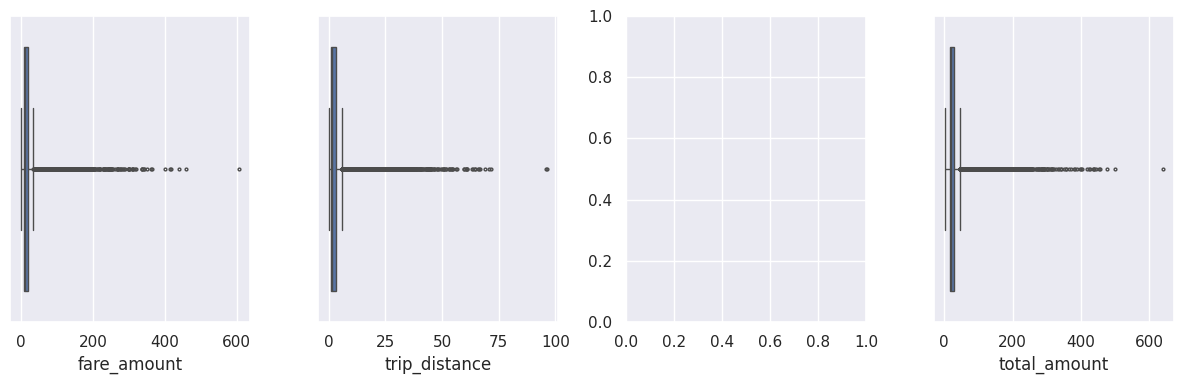

In [ ]:
# Outlier detection & removal visualization
# Convert necessary columns to Pandas Series for plotting and take a sample
sample_df = df.select("fare_amount", "trip_distance", "total_amount").sample(False, 0.1, seed=42).toPandas()

fig, axes = plt.subplots(1, 4, figsize=(12, 4))

sns.boxplot(data = sample_df, x = "fare_amount", fliersize = 2, ax = axes[0])
sns.boxplot(data = sample_df, x = "trip_distance", fliersize = 2, ax = axes[1])
#sns.boxplot(data = sample_df, x = "duration", fliersize = 2, ax = axes[2]) # 'duration' column not in selected_columns
sns.boxplot(data = sample_df, x = "total_amount", fliersize = 2, ax = axes[3]) # Fixed index to 3

plt.tight_layout()
plt.show()

In [ ]:
#Outlier detection & removal

df = df.filter((col("trip_distance") > 0) & (col("trip_distance") < 100)) #filtering rows
df = df.filter(df.fare_amount > 0)
df = df.filter(df.passenger_count > 0)
df = df.filter(df.total_amount > 0)

In [ ]:
selected_columns = [
    "vendor_id","pickup_datetime", "dropoff_datetime", "passenger_count", "trip_distance",
    "fare_amount", "tip_amount", "tolls_amount", "total_amount",
    "payment_type", "pulocation_id", "dolocation_id"
]
df = df.select(selected_columns)

In [ ]:
# Save the cleaned DataFrame as a parquet
df.write.parquet("/content/cleaned_yellow_tripdata.parquet")

In [ ]:
### END OF MILESTONE 1.
####  data cleaned, removed outliners and saved as cleaned_yellow_tripdata.parquet.